# DidgeLab tutorial part 3 - Optimization through Computational Evolution

So in the first tutorial we learned how to create didgeridoo geometries and how to analyze their sonic properties. In the second tutorial, we learned how to generate geometries from parametric shapes. In this tutorial, we will learn how to optimize the shapes through computational evolution.

In the first tutorial we defined a didgeridoo geometry and computed its sonic properties. In this tutorial, we want to reverse this: We define sonic properties and then come up with a didgeridoo geometry that has these properties. Because this is 1000x times more interesting, right?
ted
First I need to explain computational evolution and I try to make this as non-mathematical as possible.

Lets say we want to compute a Didgeridoo with a drone frequency of 73.4 Hz (which is D1). So how would you do this using the tools from tutorial 1? You would start with some kind of geometry. Maybe you already have an idea about didgeridoo acoustics, so you add a bell or make it cylindrical or you start with any other basic shape. Then you run the acoustical simulation and find out that that your didgeridoo has drone frequency for example 80 Hz. Then you change the shape. Whenever you get closer to your target (lets say you get a geometry with drone frequency 75 Hz), then you use this geometry and modify it further, until you are closer to the target.

### Loss Function

Computational evolution is very similar, except that is is automatic. It is a mathematical optimization algorithm. Now we need to get a bit mathematical, excuse me :) So it is an optimization algorithm, but what exactly do we want to optimize? We want to optimize the difference between our target properties and the properties our best geometry has. In DidgeLab, we formulate this differene as the loss function. The loss function defines how far we are away from our target. So, in above example, we could define the loss function as `loss(geo) = | drone_frequency(geo) - 73.4 Hz |`. So the loss function is the difference between the frequency of our didgeridoo and the target frequency. The `|` means that we use the absolute value: So in case our didgeridoo has drone frequency 50 Hz, then `drone_frequency(geo) - 73.4 Hz` would be negative. The absolute function turns all negative values positive. Using a loss function we can compare two didgeridoo shapes with each other and determine which one is closer to the target. The geometry that produces a lower loss is closer to the target.

Loss functions can be much more complicated than this. We can say that we want a bell size between 65 and 75mm, a certain drone frequency, certain overblow frequencies, we can add loss if the didgeridoo gets narrower instead of wider along the bore, and much more. The loss function is super important for the artificial evolution.

Computational evolution usually uses a fitness function, that determines which of two individuals (which of two didgeridoo shapes) is fitter or better. For reasons I dont remember anymore we use a loss function, so we determine which of two shapes is worse. In the end it really does not matter if you use fitness or loss, so for DidgeLab we go with loss.

## Computational evolution

So our goal is still the optimization of a didgeridoo geometries. Now we can compare two geometries which each other and find out which of the two is closer to the goal. So how exactly do we utilize that to come up with a shape that is close to the goal? First I explain the basic concept and than I explain the actual implementation, which is a bit more complex than the basic concept.

So for the basic concept, we start with a parametric shape (you remember these from tutorial 2?). This parametric shape already has some of our expectations embedded. E.g., we know that our didgeridoo should have a certain mouth piece size, a bell, and more. Also it has a set of parameters (e.g. bell size, length and others). The parameter set determines the geometry which determines the sonic properties. In computational evolution we have the notion of the "fittest" individual or the fittest parameter set, which is the individual with the smallest value of the loss function. When we begin, we have only a single individual so this is the fittest individual.

Now we randomly mutate this individual. For each mutant we compute the loss. If the loss is smaller than the loss of the fittest individual, than this mutant becomes the next fittest individual. Lets say we run this process over 1000 mutations. Each of these mutations is called a generation. At each of these 1000 generations, we mutate the fittest individual. Over the course of 1000 generations, the loss will never become bigger. The loss should always become smaller. And hopefully at the end of 1000 mutations, our geometry should have the properties which we defined over the loss.

So here you should take a deep breath and see if you understood this basic concept. Can you understand why this algorithm leads to geometries that have produce a low loss and can you understand how the loss function relates to the didgeridoo properties that we want to generate?

The actual implementation of computational evolution is a bit more complex. First of all, we do not do this one time, but several, usually 10, times. So in the end of the process we have 10 fittest individuals to choose from. We call the group of 10 mutants, that we mutate in parallel, the mutant pool.

The evolution has two phases, the exploration phase and the fine tuning phase. In the exporation phase, the mutation changes all parameters in a drastical way. In this way we try to come up with shapes that are close to what we want. In the fine tuning phase, the mutation changes only single parameters and it does not change them so drastically. In the fine tuning phase, we want to push the shapes closer to their target.

To better utilize parallelization and multiple CPU cores, each generation has a generation size, of e.g. 100. So each fittest individual in the mutant pool is mutated 100 times. Then these 100 mutations are compared to each other and the next fittest individual is selected. This determines the father shape for the next generation.

## Practical example

Enough theory. Lets define a loss function and play around with it. First we start with one of the shapes. We print the parameters of KigaliShape.

In [1]:
from didgelab import KigaliShape, acoustical_simulation, get_notes, get_log_simulation_frequencies

shape = KigaliShape(
        n_segments = 24,
        d0 = 32,
        d_bell_min = 50,
        d_bell_max = 80,
        max_length = 1900,
        min_length = 1500,
        n_bubbles = 0,
        smoothness = 0.3,
        bell_accent = 0.0,
        bell_start = 200,
        n_bell_segments = 10,
)

frequencies = get_log_simulation_frequencies(1, 1000, 5)
impedances = acoustical_simulation(shape.genome2geo(), frequencies)
get_notes(frequencies, impedances).round(2)

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,C2,-22.63,-33,64.56,31271417.00,1.00
1,E3,37.37,-17,168.41,10974368.42,0.35
2,C#4,-42.63,-8,270.44,6293723.22,0.20
3,G4,-42.63,-2,382.46,8209498.18,0.26
4,A#4,22.37,1,472.23,1898876.88,0.06
5,C#5,47.37,4,569.74,1905735.52,0.06
6,E5,42.37,7,675.59,1051321.07,0.03
7,G5,-27.63,10,771.58,464324.26,0.01
8,A#5,-7.63,13,928.23,2772926.63,0.09


And here are the initial resonant frequencies of the shape. Remember, the first resonant frequency is the drone note, the 2nd is the first toot.

Next we define a loss function. Lets say we want to make a Didgeridoo form that has a drone note of D and an octave toot. Also we want to ensure that the first three peaks have an impedance of more than 4e+06 because a peak does not need tuning alone, it also needs a certain impedance to be playable.

So here is the source code:

In [4]:
from didgelab import LossFunction, note_to_freq, acoustical_simulation, get_log_simulation_frequencies, get_notes

# first we define the loss function
class TutorialLoss(LossFunction):

    def __init__(self):
        
        self.target_notes = [-31, -19]
        self.target_freqs = [note_to_freq(note) for note in self.target_notes]
        self.min_impedance = 4e+6
    
    # Every loss function implements the loss method that computes the loss 
    # for a geometry. Do not mind the context here, we do not need it.
    def loss(self, shape):

        # we do compute the cadsd directly, but we get it from the geometry.
        # in case we need it again, we do not need to compute it a 2nd time
        # but can use it from the cache in the geo object

        frequencies = get_log_simulation_frequencies(30, 1000, 5)
        impedances = acoustical_simulation(shape.genome2geo(), frequencies)
        notes = get_notes(frequencies, impedances)

        # if we have less than 3 resonant peaks then return a super high loss
        if len(notes) < 3:
            return 1000
        
        tuning_loss = 0
        for i in range(len(self.target_freqs)):
            # we compute the squared error for deviations from the target frequency
            diff = notes.freq.iloc[i] - self.target_freqs[i]
            tuning_loss += diff * diff
            
        volume_loss = 0
        for i in range(len(self.target_freqs)):
            imp = notes.impedance.iloc[i]
            if imp < self.min_impedance:
                diff = 1+(self.min_impedance-imp)/self.min_impedance   # this is a number between 1 and 2, with 1 meaning no deviation and 2 meaning super high deviation from our goal
                diff *= 20    # we want to put a high penalty to this
                volume_loss += diff

        # we return multiple loss values as a dictionary. the evolution considers only the "loss" key. the other keys can
        # give an insight in how the different parts of the loss influence the evolution.
        loss={
            "total": tuning_loss + volume_loss,
            "tuning_loss": tuning_loss,
            "volume_loss": volume_loss,
        }
        return loss

loss = TutorialLoss()

First we defined the loss function. Then we created the parameters for the computational evolution. We can see that the FinetuningParameters define 18 parameters, 2 for each segment of the open didgeridoo geometry. The first two parameters are immutable, because we do not want the mouthpiece position to be anywhere alse than 0 and the diameter of the mouthpiece should stay at 32mm. All the other parameters can be changed within a certain region.

Next we perform an evolution. Therefore we define a processing pipeline. This pipeline consists of a single step only, the finetuning step. In this example we do not perform the exploration phase, because our shape is already almost where it should be.


Generation 5
losses: {'total': 3.72, 'tuning_loss': 3.72, 'volume_loss': 0}
  note_name  cent_diff  note_nr    freq    impedance  rel_imp         target
0        D2     -24.36      -31   72.39  30886514.32     1.00    D2 (-24.36)
1        D3     -19.36      -19  145.20  12952430.97     0.42    D3 (-19.36)
2        B3      45.64      -10  253.54   5022310.72     0.16   D3 (+945.64)
3        F4      10.64       -4  351.38   2358284.18     0.08  D3 (+1510.64)
4        A4      30.64        0  447.86   2898831.89     0.09  D3 (+1930.64)
5       C#5     -29.36        4  545.04   1177380.88     0.04  D3 (+2270.64)
6       F#5     -19.36        9  731.76   2284720.68     0.07  D3 (+2780.64)
7       G#5     -44.36       11  809.60   1043834.19     0.03  D3 (+2955.64)
8       A#5       5.64       13  935.37   3717285.43     0.12  D3 (+3205.64)


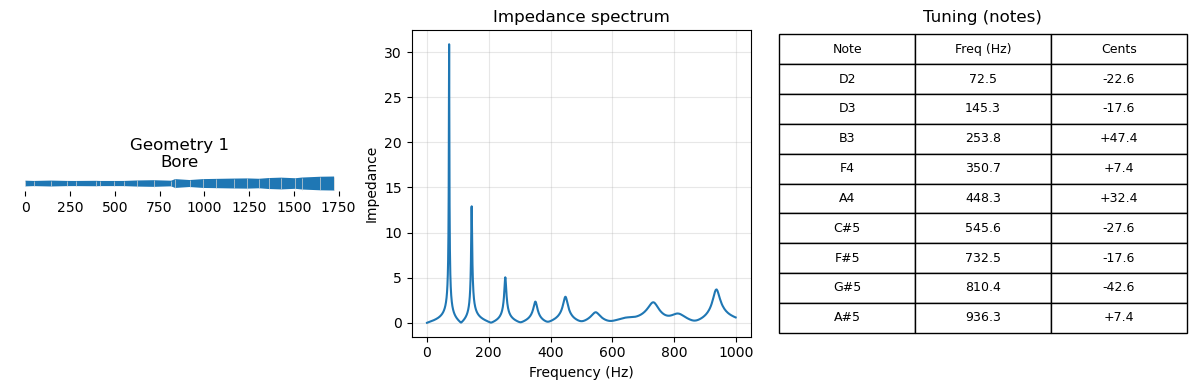

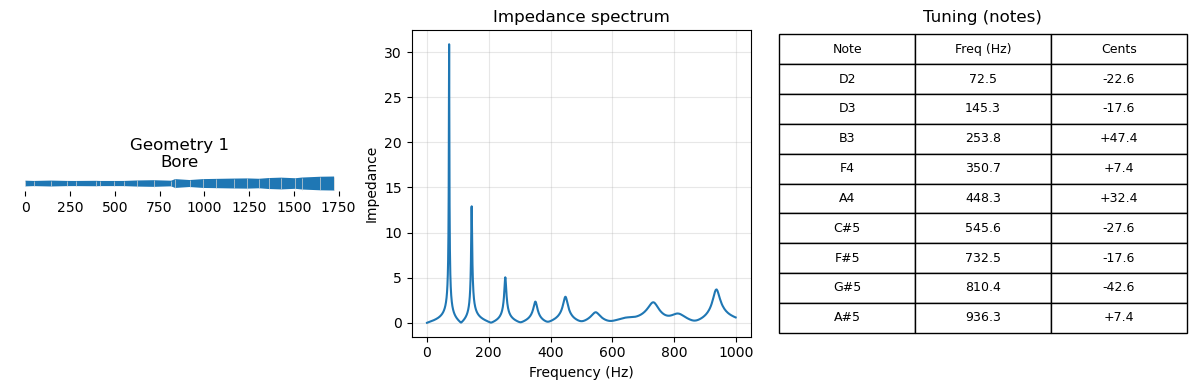

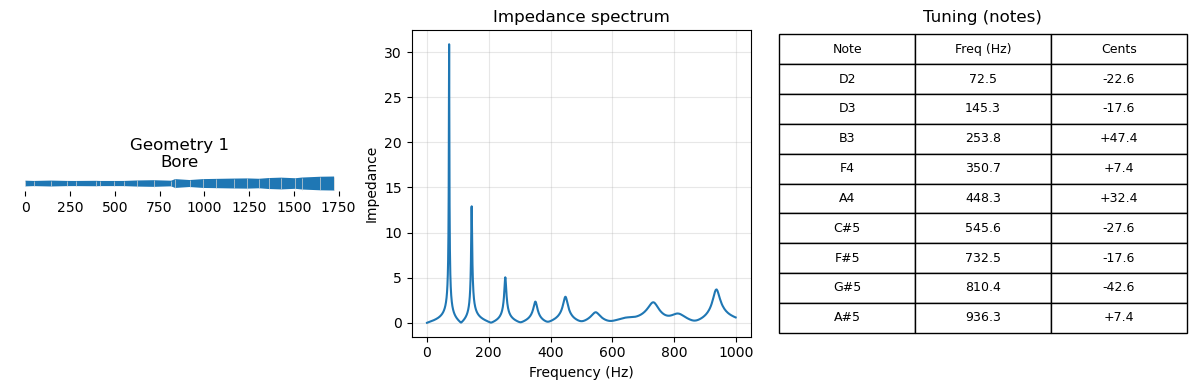

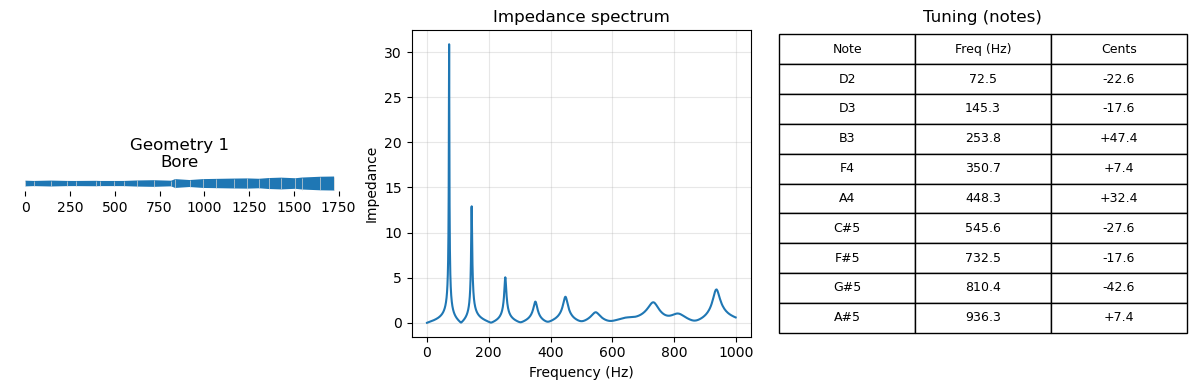

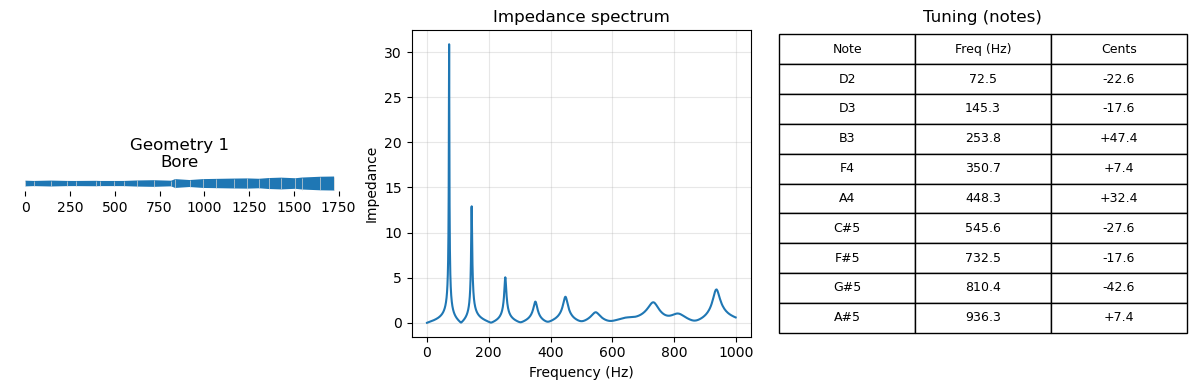

In [3]:
from didgelab import Nuevolution, init_standard_evolution

initial_population = shape.clone()

evo = Nuevolution(
    loss, 
    initial_population,
    generation_size=100, 
    num_generations=5, 
    population_size=1000)

#evo.recompute_losses = True
init_standard_evolution(loss.target_freqs, evo)

population = evo.evolve()

The next code shows how to extract the best shape from the population.

[(0.0, 32.0), (46.32870694877341, 28.959413750386904), (140.68083729622248, 33.04012900770283), (232.2329115911526, 29.204748766842993), (279.9826641422052, 28.8), (393.6485842021807, 30.51515255592485), (417.92488936793484, 28.8), (496.9135078054009, 28.8), (549.0951653425487, 29.006523445231892), (624.4343776628087, 34.202425589687934), (716.4643735694183, 37.23849778160301), (814.5137970520573, 31.499445046220416), (837.0025310903984, 49.45294577897531), (917.5965553604909, 39.105934553934304), (993.9459121507138, 49.5319634990007), (1063.4265254199934, 51.94917327633354), (1165.752023255815, 55.449103664705845), (1239.7203917704458, 57.27687869759564), (1305.6258873367028, 53.145511207543336), (1359.189298763269, 61.24369834602251), (1429.6197977160796, 65.9546464117591), (1509.1033761797862, 59.04571935306233), (1546.3332077925654, 66.9581477672871), (1645.8502958332751, 75.76561447672475), (1725.237710914864, 78.34443295310633)]


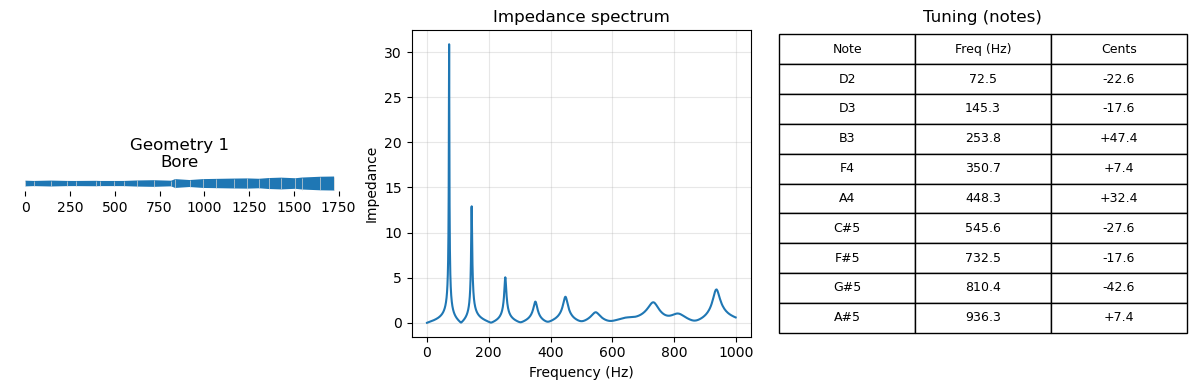

In [6]:
from didgelab import plot_geo_impedance_notes

geo=population[0].genome2geo()
fig, axes = plot_geo_impedance_notes(geo)
print(geo.geo)

Evolutions are stored on disk in the folder `ouptuts/`. You can load the latest evolution and resume it 

In [ ]:
from didgelab import Nuevolution, load_latest_evolution, init_standard_evolution

population = load_latest_evolution(shape)

evo = Nuevolution(
    loss, 
    population,
    generation_size=100, 
    num_generations=5, 
    population_size=1000)

#evo.recompute_losses = True
init_standard_evolution(loss.target_freqs, evo)

population = evo.evolve()